Notebook containing the training of FCNN-A + skip connections + dropout (FCNN-Unet )

In [449]:
import numpy as np
import pdb
import os
import pandas as pd
import matplotlib.pyplot as plt
from ExtendedImageDataGenerator import ImageDataGenerator
from model import buildModel_FCRN_A
from keras import backend as K
from keras.callbacks import ModelCheckpoint,Callback,LearningRateScheduler,CSVLogger
from scipy import misc
import scipy.ndimage as ndimage
import glob
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import load_model
from matplotlib import rcParams
rcParams["figure.figsize"] = 10, 10

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

base_path = '/home/user/placenta_masks/'
data = []
anno = []

In [3]:
def random_sample(img_id,no_samples,imgs,msks,h,w,split='train'):
    H, W = imgs.shape[0:2]
    wdw_H, wdw_W = (h,w)

    for i in range(no_samples):
        rand_var = random.random()
        y0, x0 = random.randint(0, H - wdw_H), random.randint(0, W - wdw_W)
        y1, x1 = y0 + wdw_H, x0 + wdw_W
        tmp_img = imgs[y0:y1, x0:x1]
        tmp_msk = msks[y0:y1, x0:x1]
        save_dir = 'placenta_masks/'+split+'_crop_imgs/crop_'+str(i)+'_'+img_id.split('/')[2]
        misc.imsave(save_dir,tmp_img)
        save_dir = 'placenta_masks/'+split+'_crop_msks/crop_'+str(i)+'_'+img_id.split('/')[2]
        misc.imsave(save_dir,tmp_msk)

In [4]:
train_imgs = glob.glob('FCNN_dataset/training_imgs/*.png')
train_imgs.sort()
train_msks =glob.glob('FCNN_dataset/training_masks/*.png')
train_msks.sort()

val_imgs = glob.glob('FCNN_dataset/valid_imgs/*.png')
val_imgs.sort()
val_msks =glob.glob('FCNN_dataset/valid_masks/*.png')
val_msks.sort()

In [5]:
def load_files(img_list,masks=False):
    img_array=[]
    for i in img_list:
        img = misc.imread(i)
        img_array.append(img)
    return img_array


# In[35]:

all_train_imgs = load_files(train_imgs)
all_train_msks = load_files(train_msks,masks=True)

print(len(all_train_imgs),len(all_train_msks))
###
all_valid_imgs = load_files(val_imgs)
all_valid_msks = load_files(val_msks,masks=True)
print(len(all_valid_imgs),len(all_valid_msks))

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


71 71
10 10


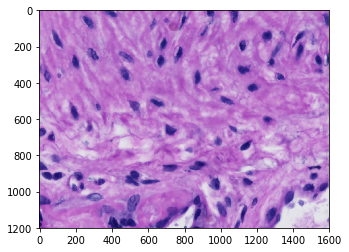

In [6]:
plt.imshow(all_valid_imgs[9])

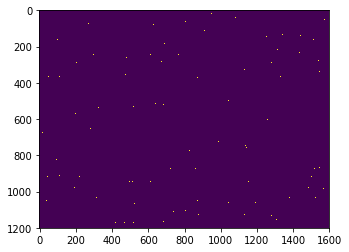

In [7]:
plt.imshow(all_valid_msks[9])

In [ ]:
import random
for index,entry in enumerate(train_imgs):
    img_id = train_imgs[index]
    random_sample(img_id,500,all_train_imgs[index],all_train_msks[index],256,256,split='train')


In [ ]:
for index,entry in enumerate(val_imgs):
    img_id = val_imgs[index]
    random_sample(img_id,200,all_valid_imgs[index],all_valid_msks[index],256,256,split='valid')


In [9]:
train_imgs=glob.glob('/home/user/placenta_masks/train_crop_imgs/*.png')
train_imgs.sort()
train_msks=glob.glob('/home/user/placenta_masks/train_crop_msks/*.png')
train_msks.sort()


valid_imgs=glob.glob('/home/user/placenta_masks/valid_crop_imgs/*.png')
valid_imgs.sort()
valid_msks=glob.glob('/home/user/placenta_masks/valid_crop_msks/*.png')
valid_msks.sort()

In [10]:
def step_decay(epoch):
    step = 16
    num =  epoch // step 
    if num % 3 == 0:
        lrate = 1e-2
    elif num % 3 == 1:
        lrate = 1e-3
    else:
        lrate = 1e-4
        #lrate = initial_lrate * 1/(1 + decay * (epoch - num * step))
    print('Learning rate for epoch {} is {}.'.format(epoch+1, lrate))
    return np.float(lrate)

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


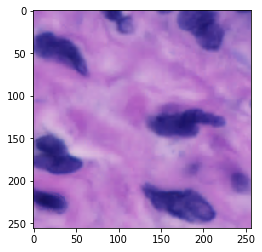

In [11]:
plt.imshow(misc.imread(valid_imgs[18])/255.)

In [12]:
ex = misc.imread(valid_msks[18])

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [13]:
ex = ndimage.gaussian_filter(ex*100, sigma=(1, 1), order=0)

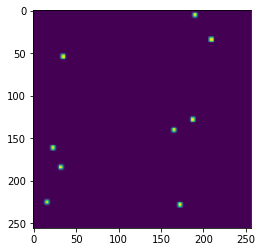

In [14]:
plt.imshow(ex)

In [15]:
print('Training images: {}'.format(len(train_imgs)))
print('Training mask: {}'.format(len(train_msks)))

print('Validation images: {}'.format(len(valid_imgs)))
print('Validation mask: {}'.format(len(valid_msks)))

Training images: 35500
Training mask: 35500
Validation images: 2000
Validation mask: 2000


In [16]:
def read_data(imgs,msks):
    data=[]
    anno=[]
    for i in range(len(imgs)): 
        img1 = misc.imread(imgs[i])
        data.append(np.array(img1))
        img2_ = misc.imread(msks[i])
        img2_ = np.expand_dims(img2_, axis = -1)
        img2 = 100.0 * (img2_[:,:,0] > 0)
        img2 = ndimage.gaussian_filter(img2, sigma=(1, 1), order=0)
        anno.append(img2)
    return np.array(data, dtype='float32'), np.array(anno, dtype='float32')

In [17]:
x_img,x_msk=read_data(train_imgs[0:2],train_msks[0:2])

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


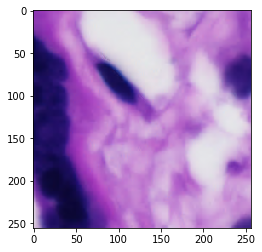

In [18]:
plt.imshow(x_img[1]/255.)

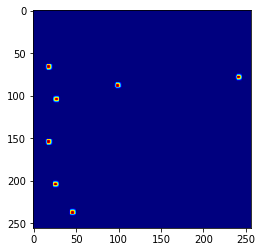

In [19]:
plt.imshow(x_msk[1],cmap='jet')

In [20]:
def train_():
#     data, anno = read_data(imgs,msks)
    train_data_tmp,train_anno_tmp = read_data(train_imgs,train_msks)
    train_data_tmp = train_data_tmp / 255.
    
    train_data = train_data_tmp
    train_anno = train_anno_tmp
    #val_data = train_data_tmp[25000:]
    #val_anno = train_anno_tmp[25000:]
    val_data,val_anno = read_data(valid_imgs,valid_msks)
    val_data = val_data / 255.
    val_anno = np.expand_dims(val_anno, axis = -1)
    train_anno = np.expand_dims(train_anno, axis = -1)

    batch_size=32
    
    print('-'*30)
    print('Creating and compiling the fully convolutional regression networks.')
    print('-'*30)    
    
    model = buildModel_FCRN_A(input_dim = (256,256,3))
    model_checkpoint = ModelCheckpoint('cell_counting.hdf5', monitor='val_loss', save_best_only=True)
    model.summary()
    print('...Fitting model...')
    print('-'*30)
    change_lr = LearningRateScheduler(step_decay)

    img_datagen = ImageDataGenerator(horizonal_flip = True, vertical_flip = True)
    val_img_datagen = ImageDataGenerator()
#     # Provide the same seed and keyword arguments to the fit and flow methods

#     # Provide the same seed and keyword arguments to the fit and flow methods

    csv_logger = CSVLogger('training.log')
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(img_datagen.flow(train_data,train_anno,seed=42,batch_size=32),
                        steps_per_epoch = round(train_data.shape[0]/batch_size),
                        validation_data=val_img_datagen.flow(val_data,val_anno,seed=42,batch_size=20),
                        validation_steps=round(val_data.shape[0]/batch_size),
                        nb_epoch = 150,
                        callbacks = [model_checkpoint, change_lr,csv_logger],
                        verbose=1
                       )


In [23]:
if __name__ == '__main__':
    train_()

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


------------------------------
Creating and compiling the fully convolutional regression networks.
------------------------------


/home/user/model.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), strides=(1, 1), padding="same", kernel_initializer="orthogonal", use_bias=False)`
  border_mode='same', bias = False)(input)
/home/user/model.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer="orthogonal", use_bias=False)`
  border_mode='same', bias = False)(input)
/home/user/model.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), strides=(1, 1), padding="same", kernel_initializer="orthogonal", use_bias=False)`
  border_mode='same', bias = False)(input)
/home/user/model.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), strides=(1, 1), padding="same", kernel_initializer="orthogonal", use_bias=False)`
  border_mode='same', bias = False)(input)
/home/user/model.py:83: UserWarning: The `merge` function is deprecated and will be re

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      864       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18432     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
__________

KeyboardInterrupt: 

In [21]:
model = load_model('cell_counting.hdf5')

In [22]:
val_data,val_anno = read_data(valid_imgs,valid_msks)
val_data = val_data/255.

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


In [23]:
A = model.predict(val_data)

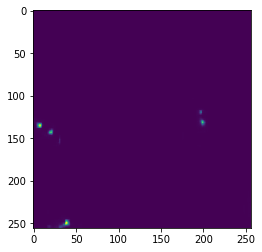

In [24]:
plt.imshow(np.reshape(A[31],(256,256)))

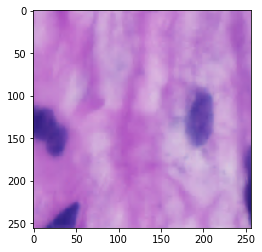

In [25]:
plt.imshow(np.array(val_data[31]))

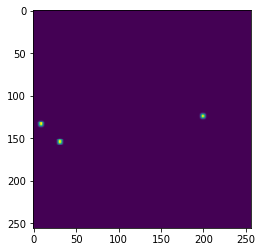

In [26]:
plt.imshow(val_anno[31])

In [27]:
def sliding_window(img_id,img,h,w,masks=False):
    img_crops=[]
    img_preds=[]
    img_h,img_w = img.shape[0:2]
    img = Image.fromarray(img)
    for i in range(0,img_w-w,w):
        for j in range(0,img_h-h,h):
            crp = img.crop((i,j,w+i,h+j))
            crp = np.array(crp)/255.
            img_crops.append(crp)
            crp = np.expand_dims(crp,axis=0)
            pred = model.predict(crp)
            save_dir = 'placenta_masks/sliding/crop_'+str(i)+"_"+str(j)+'_'+img_id.split('/')[2].split('.')[0]+'.jpg'
            pred = np.reshape(pred,(256,256))
#             pred = Image.fromarray(pred)
            img_preds.append(pred)
    return img_crops,img_preds

In [36]:
img,preds = sliding_window(val_imgs[8],all_valid_imgs[8],256,256)

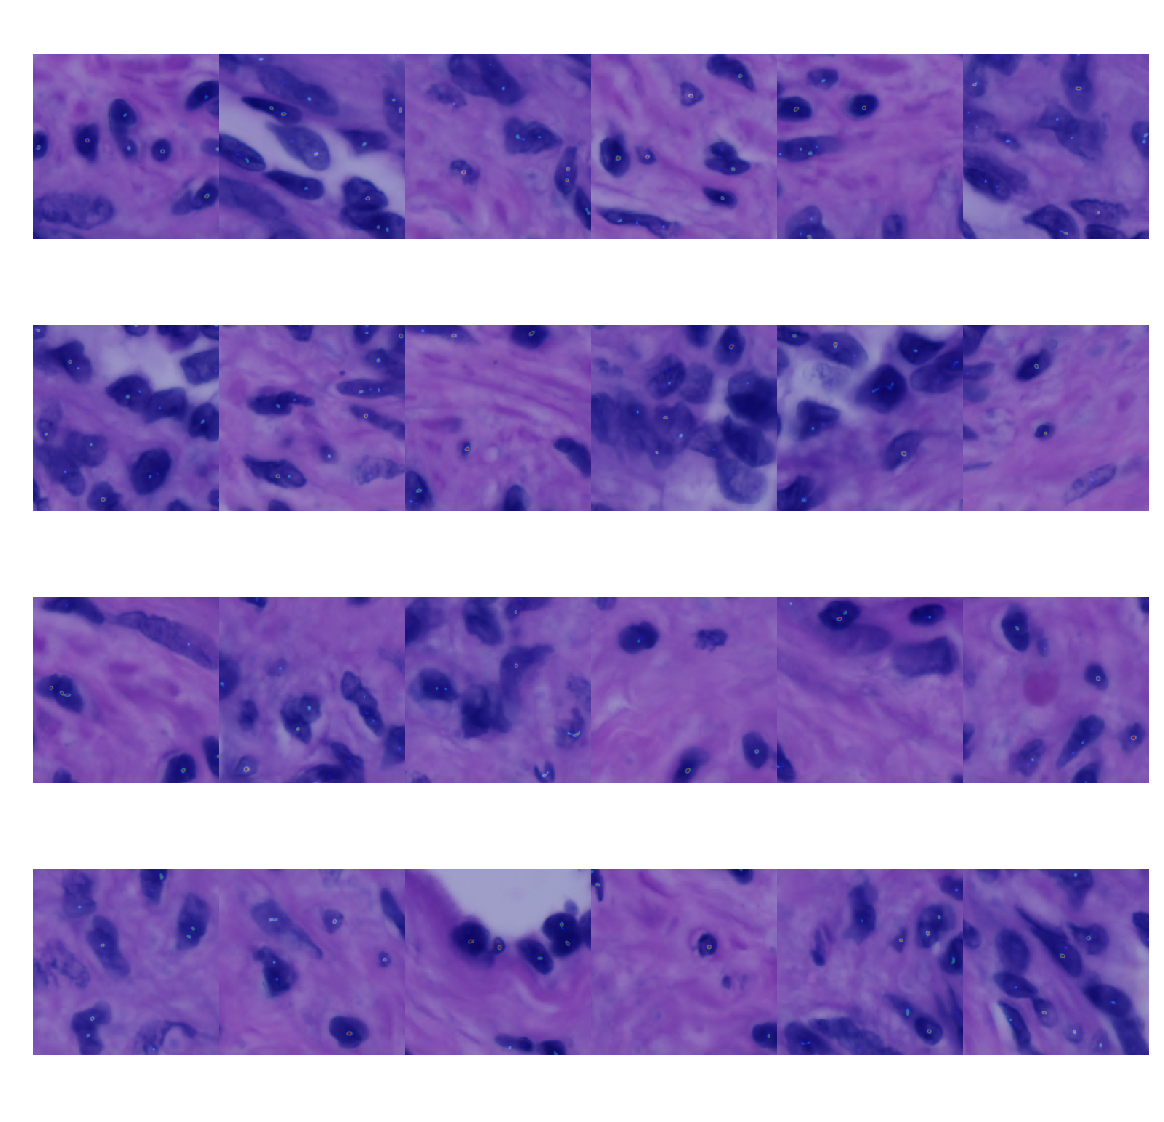

In [39]:
w=10
h=10
fig=plt.figure(figsize=(20, 20))
fig.subplots_adjust(wspace=0, hspace=0)
columns = 6
rows = 4
for i in range(1, columns*rows + 1):
    plt.axis('off')
    fig.add_subplot(rows, columns, i)
    plt.imshow(preds[i-1],alpha=1,cmap='jet')
    plt.imshow(img[i-1],alpha=0.7)
    plt.axis('off')



Now we will attempt to fine-tune the predictions by using the whole image tile (1200x1600) > (256x256) much like they did in the original FCNN paper.

In [234]:
all_train_imgs_256=[]
all_train_msks_256=[]
for i,img in enumerate(all_train_imgs):
    all_train_imgs_256.append(Image.fromarray(img).resize((256,256)))
    all_train_msks_256.append(Image.fromarray(all_train_msks[i]).resize((256,256)))

In [235]:
all_train_imgs_256=[np.array(i)/255. for i in all_train_imgs_256]
all_train_msks_256=[np.array(i) for i in all_train_msks_256]

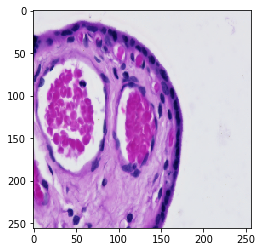

In [236]:
plt.imshow(all_train_imgs_256[0])

In [237]:
all_train_msks_256[0].shape

(256, 256)

In [238]:
all_train_imgs_256[0].shape


(256, 256, 3)

In [239]:
all_train_msks_256 = [ndimage.gaussian_filter(img, sigma=(1, 1), order=0) for img in all_train_msks_256]
all_train_msks_256 = np.array([np.expand_dims(img,axis=-1) for img in all_train_msks_256],dtype='float32')


In [240]:
all_valid_imgs_256=[]
all_valid_msks_256=[]
for i,img in enumerate(all_valid_imgs):
    all_valid_imgs_256.append(Image.fromarray(img).resize((256,256)))
    all_valid_msks_256.append(Image.fromarray(all_valid_msks[i]).resize((256,256)))
all_valid_imgs_256=[np.array(i)/255. for i in all_valid_imgs_256]


In [241]:
all_valid_msks_256 = [ndimage.gaussian_filter(img, sigma=(1, 1), order=0) for img in all_valid_msks_256]
all_valid_msks_256 = np.array([np.expand_dims(img,axis=-1) for img in all_valid_msks_256],dtype='float32')


In [242]:
all_train_imgs_256 = np.array(all_train_imgs_256)
all_valid_imgs_256 = np.array(all_valid_imgs_256)

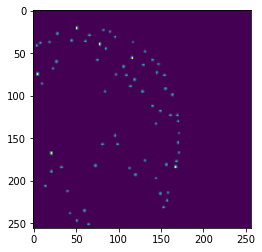

In [243]:
plt.imshow(all_train_msks_256[0][:,:,0])

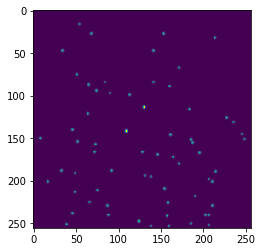

In [244]:
plt.imshow(all_valid_msks_256[0][:,:,0])

In [264]:
def step_decay(epoch):
    step = 16
    num =  epoch // step 
    if num % 3 == 0:
        lrate = 1e-2
    elif num % 3 == 1:
        lrate = 1e-3
    else:
        lrate = 1e-4
        #lrate = initial_lrate * 1/(1 + decay * (epoch - num * step))
    print('Learning rate for epoch {} is {}.'.format(epoch+1, lrate))
    return np.float(lrate)

In [348]:
def fine_tune(all_train_imgs_256,all_train_msks_256,all_valid_imgs_256,all_valid_msks_256):
    batch_size=32
    print('-'*30)
    print('Creating and compiling the fully convolutional regression networks.')
    print('-'*30)    
    
    model = load_model('cell_counting.hdf5')
    model_checkpoint = ModelCheckpoint('cell_counting_finetune.hdf5', monitor='val_loss', save_best_only=True)
    model.summary()
    print('...Fitting model...')
    print('-'*30)
    change_lr = LearningRateScheduler(step_decay)

    img_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True)
    val_img_datagen = ImageDataGenerator()

    csv_logger = CSVLogger('training.log')
    model.fit_generator(img_datagen.flow(all_train_imgs_256,all_train_msks_256,seed=42,batch_size=32),
                        steps_per_epoch = round(all_train_imgs_256.shape[0]/batch_size),
                        validation_data = val_img_datagen.flow(all_valid_imgs_256,all_valid_msks_256,seed=42,batch_size=10),
                        validation_steps = 1,
                        nb_epoch = 600,
                        callbacks = [model_checkpoint, change_lr,csv_logger],
                        verbose=1
                       )


In [349]:
fine_tune(all_train_imgs_256,all_train_msks_256,all_valid_imgs_256,all_valid_msks_256)

------------------------------
Creating and compiling the fully convolutional regression networks.
------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      864       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18432     
____________

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<ExtendedI..., steps_per_epoch=2, validation_data=<ExtendedI..., validation_steps=1, callbacks=[<keras.ca..., verbose=1, epochs=600)`


Learning rate for epoch 1 is 0.01.
2/2 [==============================] - 4s 2s/step - loss: 12.9190 - val_loss: 6.1405
Epoch 2/600
Learning rate for epoch 2 is 0.01.
2/2 [==============================] - 0s 217ms/step - loss: 11.2207 - val_loss: 6.1023
Epoch 3/600
Learning rate for epoch 3 is 0.01.
2/2 [==============================] - 0s 204ms/step - loss: 12.1390 - val_loss: 6.0662
Epoch 4/600
Learning rate for epoch 4 is 0.01.
2/2 [==============================] - 1s 318ms/step - loss: 11.0263 - val_loss: 6.0154
Epoch 5/600
Learning rate for epoch 5 is 0.01.
2/2 [==============================] - 0s 204ms/step - loss: 10.6909 - val_loss: 5.9500
Epoch 6/600
Learning rate for epoch 6 is 0.01.
2/2 [==============================] - 0s 203ms/step - loss: 10.8934 - val_loss: 5.8933
Epoch 7/600
Learning rate for epoch 7 is 0.01.
2/2 [==============================] - 1s 319ms/step - loss: 10.8969 - val_loss: 5.8646
Epoch 8/600
Learning rate for epoch 8 is 0.01.
2/2 [==================

2/2 [==============================] - 0s 207ms/step - loss: 9.8485 - val_loss: 5.3328
Epoch 120/600
Learning rate for epoch 120 is 0.001.
2/2 [==============================] - 0s 203ms/step - loss: 9.4808 - val_loss: 5.3287
Epoch 121/600
Learning rate for epoch 121 is 0.001.
2/2 [==============================] - 1s 317ms/step - loss: 9.9249 - val_loss: 5.3248
Epoch 122/600
Learning rate for epoch 122 is 0.001.
2/2 [==============================] - 0s 204ms/step - loss: 10.6607 - val_loss: 5.3200
Epoch 123/600
Learning rate for epoch 123 is 0.001.
2/2 [==============================] - 0s 204ms/step - loss: 9.2236 - val_loss: 5.3159
Epoch 124/600
Learning rate for epoch 124 is 0.001.
2/2 [==============================] - 1s 317ms/step - loss: 9.9735 - val_loss: 5.3125
Epoch 125/600
Learning rate for epoch 125 is 0.001.
2/2 [==============================] - 0s 206ms/step - loss: 9.4869 - val_loss: 5.3093
Epoch 126/600
Learning rate for epoch 126 is 0.001.
2/2 [=====================

2/2 [==============================] - 1s 319ms/step - loss: 9.5102 - val_loss: 5.2242
Epoch 179/600
Learning rate for epoch 179 is 0.0001.
2/2 [==============================] - 0s 203ms/step - loss: 11.2223 - val_loss: 5.2243
Epoch 180/600
Learning rate for epoch 180 is 0.0001.
2/2 [==============================] - 0s 209ms/step - loss: 9.2375 - val_loss: 5.2237
Epoch 181/600
Learning rate for epoch 181 is 0.0001.
2/2 [==============================] - 1s 325ms/step - loss: 9.7277 - val_loss: 5.2232
Epoch 182/600
Learning rate for epoch 182 is 0.0001.
2/2 [==============================] - 0s 205ms/step - loss: 10.2407 - val_loss: 5.2231
Epoch 183/600
Learning rate for epoch 183 is 0.0001.
2/2 [==============================] - 0s 210ms/step - loss: 9.2337 - val_loss: 5.2221
Epoch 184/600
Learning rate for epoch 184 is 0.0001.
2/2 [==============================] - 1s 318ms/step - loss: 9.7312 - val_loss: 5.2215
Epoch 185/600
Learning rate for epoch 185 is 0.0001.
2/2 [=============

2/2 [==============================] - 0s 206ms/step - loss: 10.1125 - val_loss: 5.1518
Epoch 238/600
Learning rate for epoch 238 is 0.0001.
2/2 [==============================] - 1s 321ms/step - loss: 9.7824 - val_loss: 5.1512
Epoch 239/600
Learning rate for epoch 239 is 0.0001.
2/2 [==============================] - 0s 206ms/step - loss: 9.8803 - val_loss: 5.1505
Epoch 240/600
Learning rate for epoch 240 is 0.0001.
2/2 [==============================] - 0s 209ms/step - loss: 9.3353 - val_loss: 5.1499
Epoch 241/600
Learning rate for epoch 241 is 0.01.
2/2 [==============================] - 1s 317ms/step - loss: 9.7228 - val_loss: 5.1499
Epoch 242/600
Learning rate for epoch 242 is 0.01.
2/2 [==============================] - 0s 208ms/step - loss: 9.5259 - val_loss: 5.1536
Epoch 243/600
Learning rate for epoch 243 is 0.01.
2/2 [==============================] - 0s 207ms/step - loss: 9.9779 - val_loss: 5.1427
Epoch 244/600
Learning rate for epoch 244 is 0.01.
2/2 [======================

2/2 [==============================] - 0s 204ms/step - loss: 10.0228 - val_loss: 5.0861
Epoch 297/600
Learning rate for epoch 297 is 0.01.
2/2 [==============================] - 0s 204ms/step - loss: 9.4636 - val_loss: 5.0951
Epoch 298/600
Learning rate for epoch 298 is 0.01.
2/2 [==============================] - 1s 320ms/step - loss: 9.2542 - val_loss: 5.1070
Epoch 299/600
Learning rate for epoch 299 is 0.01.
2/2 [==============================] - 0s 208ms/step - loss: 10.6971 - val_loss: 5.0934
Epoch 300/600
Learning rate for epoch 300 is 0.01.
2/2 [==============================] - 0s 210ms/step - loss: 10.3008 - val_loss: 5.0812
Epoch 301/600
Learning rate for epoch 301 is 0.01.
2/2 [==============================] - 1s 318ms/step - loss: 9.6244 - val_loss: 5.0786
Epoch 302/600
Learning rate for epoch 302 is 0.01.
2/2 [==============================] - 0s 204ms/step - loss: 9.3695 - val_loss: 5.0933
Epoch 303/600
Learning rate for epoch 303 is 0.01.
2/2 [==========================

2/2 [==============================] - 1s 321ms/step - loss: 9.5351 - val_loss: 5.0651
Epoch 356/600
Learning rate for epoch 356 is 0.001.
2/2 [==============================] - 0s 207ms/step - loss: 9.4227 - val_loss: 5.0662
Epoch 357/600
Learning rate for epoch 357 is 0.001.
2/2 [==============================] - 0s 206ms/step - loss: 9.7804 - val_loss: 5.0654
Epoch 358/600
Learning rate for epoch 358 is 0.001.
2/2 [==============================] - 1s 321ms/step - loss: 9.5243 - val_loss: 5.0632
Epoch 359/600
Learning rate for epoch 359 is 0.001.
2/2 [==============================] - 0s 205ms/step - loss: 9.7404 - val_loss: 5.0592
Epoch 360/600
Learning rate for epoch 360 is 0.001.
2/2 [==============================] - 0s 209ms/step - loss: 8.9972 - val_loss: 5.0560
Epoch 361/600
Learning rate for epoch 361 is 0.001.
2/2 [==============================] - 1s 320ms/step - loss: 9.6621 - val_loss: 5.0524
Epoch 362/600
Learning rate for epoch 362 is 0.001.
2/2 [======================

2/2 [==============================] - 0s 207ms/step - loss: 9.1161 - val_loss: 5.0044
Epoch 415/600
Learning rate for epoch 415 is 0.001.
2/2 [==============================] - 1s 323ms/step - loss: 9.4071 - val_loss: 5.0052
Epoch 416/600
Learning rate for epoch 416 is 0.001.
2/2 [==============================] - 0s 207ms/step - loss: 9.8988 - val_loss: 5.0063
Epoch 417/600
Learning rate for epoch 417 is 0.0001.
2/2 [==============================] - 0s 206ms/step - loss: 8.9463 - val_loss: 5.0074
Epoch 418/600
Learning rate for epoch 418 is 0.0001.
2/2 [==============================] - 1s 321ms/step - loss: 9.4104 - val_loss: 5.0084
Epoch 419/600
Learning rate for epoch 419 is 0.0001.
2/2 [==============================] - 0s 207ms/step - loss: 9.7867 - val_loss: 5.0094
Epoch 420/600
Learning rate for epoch 420 is 0.0001.
2/2 [==============================] - 0s 209ms/step - loss: 8.7878 - val_loss: 5.0100
Epoch 421/600
Learning rate for epoch 421 is 0.0001.
2/2 [=================

2/2 [==============================] - 0s 206ms/step - loss: 10.1570 - val_loss: 4.9913
Epoch 474/600
Learning rate for epoch 474 is 0.0001.
2/2 [==============================] - 0s 206ms/step - loss: 9.0451 - val_loss: 4.9911
Epoch 475/600
Learning rate for epoch 475 is 0.0001.
2/2 [==============================] - 1s 322ms/step - loss: 9.2949 - val_loss: 4.9909
Epoch 476/600
Learning rate for epoch 476 is 0.0001.
2/2 [==============================] - 0s 205ms/step - loss: 9.7413 - val_loss: 4.9910
Epoch 477/600
Learning rate for epoch 477 is 0.0001.
2/2 [==============================] - 0s 207ms/step - loss: 9.3198 - val_loss: 4.9907
Epoch 478/600
Learning rate for epoch 478 is 0.0001.
2/2 [==============================] - 1s 320ms/step - loss: 9.3758 - val_loss: 4.9906
Epoch 479/600
Learning rate for epoch 479 is 0.0001.
2/2 [==============================] - 0s 206ms/step - loss: 9.2365 - val_loss: 4.9904
Epoch 480/600
Learning rate for epoch 480 is 0.0001.
2/2 [==============

2/2 [==============================] - 1s 320ms/step - loss: 9.3404 - val_loss: 4.9826
Epoch 533/600
Learning rate for epoch 533 is 0.01.
2/2 [==============================] - 0s 206ms/step - loss: 9.2418 - val_loss: 4.9922
Epoch 534/600
Learning rate for epoch 534 is 0.01.
2/2 [==============================] - 0s 210ms/step - loss: 10.1970 - val_loss: 4.9747
Epoch 535/600
Learning rate for epoch 535 is 0.01.
2/2 [==============================] - 1s 325ms/step - loss: 9.3913 - val_loss: 4.9731
Epoch 536/600
Learning rate for epoch 536 is 0.01.
2/2 [==============================] - 0s 209ms/step - loss: 9.5935 - val_loss: 4.9913
Epoch 537/600
Learning rate for epoch 537 is 0.01.
2/2 [==============================] - 0s 208ms/step - loss: 8.5304 - val_loss: 5.0000
Epoch 538/600
Learning rate for epoch 538 is 0.01.
2/2 [==============================] - 1s 323ms/step - loss: 9.6011 - val_loss: 4.9888
Epoch 539/600
Learning rate for epoch 539 is 0.01.
2/2 [============================

2/2 [==============================] - 0s 209ms/step - loss: 9.3591 - val_loss: 4.9709
Epoch 592/600
Learning rate for epoch 592 is 0.01.
2/2 [==============================] - 1s 324ms/step - loss: 9.2545 - val_loss: 4.9657
Epoch 593/600
Learning rate for epoch 593 is 0.001.
2/2 [==============================] - 0s 208ms/step - loss: 9.6192 - val_loss: 4.9671
Epoch 594/600
Learning rate for epoch 594 is 0.001.
2/2 [==============================] - 0s 211ms/step - loss: 8.9387 - val_loss: 4.9689
Epoch 595/600
Learning rate for epoch 595 is 0.001.
2/2 [==============================] - 1s 323ms/step - loss: 9.2822 - val_loss: 4.9676
Epoch 596/600
Learning rate for epoch 596 is 0.001.
2/2 [==============================] - 0s 210ms/step - loss: 9.3251 - val_loss: 4.9627
Epoch 597/600
Learning rate for epoch 597 is 0.001.
2/2 [==============================] - 0s 207ms/step - loss: 9.1751 - val_loss: 4.9571
Epoch 598/600
Learning rate for epoch 598 is 0.001.
2/2 [=======================

In [350]:
model = load_model('cell_counting_finetune.hdf5')

In [374]:
test_imgs = load_files(glob.glob('keras-retinanet/placenta/10_m*'))

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


In [375]:
all_test_imgs_256=[]
for i,img in enumerate(test_imgs):
    all_test_imgs_256.append(Image.fromarray(img).resize((256,256)))
all_test_imgs_256=[np.array(i)/255. for i in all_test_imgs_256]


In [377]:
all_test_imgs_256 = np.array(all_test_imgs_256)

In [381]:
test_preds = model.predict(np.array(all_test_imgs_256))

In [382]:
test_preds = [np.reshape(i,(256,256)) for i in test_preds]

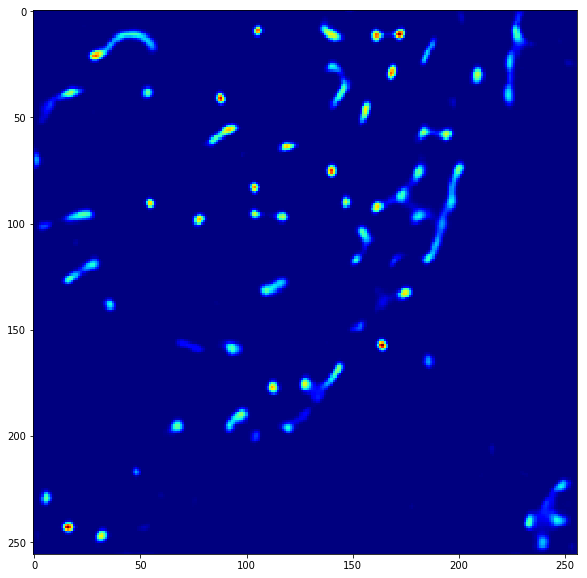

In [408]:
plt.imshow(test_preds[7],cmap='jet')

Let's get coordinates for each of the nuclei using difference of guassians so we can compare to retinanet:

In [406]:
from skimage.feature import blob_dog
coords = blob_dog(test_preds[7]/np.max(test_preds[7]), min_sigma = 0.01, max_sigma = 5, threshold = 0.2, sigma_ratio = 5)

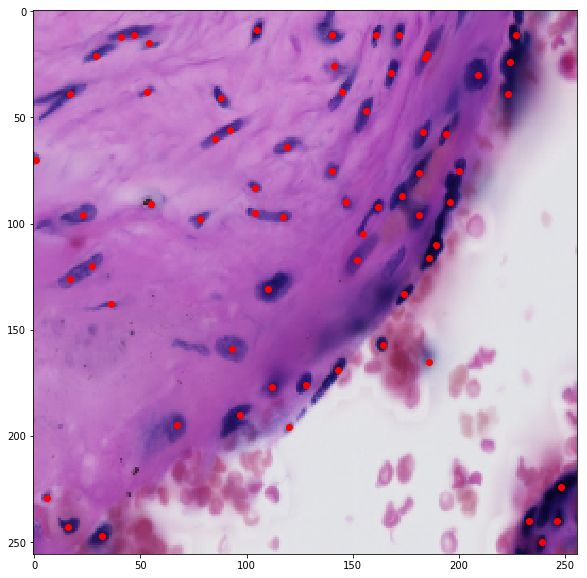

In [435]:
plt.imshow(all_test_imgs_256[7],cmap='jet');
plt.scatter(coords[:, 1], coords[:, 0], color = "red", marker = "o")


In [442]:
import pickle
# load the retina net prediction
image10 = open('keras-retinanet/test_preds/all_image10_predictions.pkl','rb')
image10_test = pickle.load(image10)

In [451]:
coords=pd.DataFrame(coords)

In [452]:
coords['filename'] = '10_m00257_ORG.png'

In [453]:
coords.head()

,0,1,2,filename
0,250.0,239.0,1.25,10_m00257_ORG.png
1,247.0,32.0,1.25,10_m00257_ORG.png
2,243.0,16.0,1.25,10_m00257_ORG.png
3,240.0,246.0,1.25,10_m00257_ORG.png
4,240.0,233.0,1.25,10_m00257_ORG.png
